### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [30]:
from geopy.distance import geodesic
from shapely.geometry import Point
import numpy as np
import folium
from folium.features import DivIcon
import pandas as pd

mipt = Point(55.9297243, 37.5199434)
kremlin = Point(55.752023, 37.6174994)

Вариант 1

Самый простой вариант - используем готовую функцию

In [2]:
def get_geodesic_distance_simple(point1, point2):
    return geodesic((point1.x, point1.y), (point2.x, point2.y)).km
get_geodesic_distance_simple(mipt, kremlin)

20.70755124016457

Вариант 2

Рассчитываем по формулам сферической тригонометрии в предположении, что Земля - шар

In [3]:
def get_geodesic_distance(point1, point2, earth_radius = 6372795):
    """
    Возвращает геодезическое расстояние между объектами в предположении шарообразоности Земли.
    :param point1: координаты первой точки в виде shapely.geometry.Point
    :param point1: координаты первой точки в виде shapely.geometry.Point
    :param earth_radius: средний радиус Земли
    
    :return: геодезическое расстояние между точками в километрах
    """
    #  Получаем из исходных точек широты phi и долготы lambda
    phi1 = point1.x * np.pi / 180.0
    lambda1 = point1.y * np.pi / 180.0
    phi2 = point2.x * np.pi / 180.0
    lambda2 = point2.y * np.pi / 180.0
    # Рассчитываем вспомогательные величины
    delta_1 = np.sin(phi1) * np.sin(phi2) + np.cos(phi1) * np.cos(phi2) * np.cos(lambda1 - lambda2)
    delta_2 = np.sqrt(np.power(np.cos(phi2) * np.sin(lambda1 - lambda2), 2) + (
        np.power(np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(lambda1 - lambda2), 2)))
    return np.arctan(delta_2 / delta_1) * earth_radius / 1000

In [4]:
get_geodesic_distance(mipt, kremlin)

20.682777632077542

### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from shapely.ops import nearest_points
%matplotlib inline

big_moscow_districts = gpd.read_file('../data/big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

In [6]:
polygons_df = gpd.GeoDataFrame()
# Записываем в датафрейм полигоны
polygons_df["geometry"] = polygons
polygons_df.to_json()
gpd.GeoDataFrame({'geometry': polygons}).to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[37.72450370000001, 55.589313100000005], [37.724051, 55.58913330000001], [37.719658100000004, 55.5873263], [37.7161644, 55.586000399999996], [37.71599810000001, 55.585893399999996], [37.715551000000005, 55.585741399999996], [37.7129495, 55.584802999999994], [37.711380399999996, 55.5842369], [37.710109900000006, 55.58377], [37.7082445, 55.5830899], [37.7075249, 55.5828219], [37.70621930000001, 55.58233380000001], [37.704644099999996, 55.581748], [37.704748, 55.581656499999994], [37.703425900000006, 55.5811787], [37.7032964, 55.5812799], [37.700929, 55.580395900000006], [37.701058200000006, 55.580272900000004], [37.7002971, 55.57999280000001], [37.699400700000005, 55.5796826], [37.69905210000001, 55.57955320000001], [37.69643630000001, 55.5785494], [37.6926914, 55.577159800000004], [37.69256430000001, 55.5771246], [37.69223780000001, 55.5768748], [

#### Функция

In [82]:
def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    # Проверяем, что k не больше, чем количество полигонов
    k = len(polygons) if k > len(polygons) else k
    # Проверяем, что в списке полигонов нет исследуемого полигона
    if polygon in polygons:
        polygons.remove(polygon)
    
#     # Расчёт через центроиды полигонов
#     if kind == 'by_centroid':
#         # Сортируем полигоны по геодезическому расстоянию между центроидами
#         polygons.sort(key=lambda polygon_: get_geodesic_distance(polygon.centroid, polygon_.centroid))
#     # Расчёт через ближайшие точки на границах полигонов
#     if kind == 'by_board':
#         polygons.sort(key=lambda polygon_: get_geodesic_distance(*nearest_points(polygon, polygon_)))
    
    # Создаём датафрейм с полигонами и расстояниями
    polygons_df = gpd.GeoDataFrame()
    # Записываем в датафрейм полигоны
    polygons_df["geometry"] = polygons
    # Записываем в датафрейм расстояния между исследуемым полигоном и другими полигонами
    polygons_df["Distance_by_board"] = polygons_df["geometry"].apply(
        lambda polygon_: get_geodesic_distance(*nearest_points(polygon, polygon_)))
    polygons_df["Distance_by_centroid"] = polygons_df["geometry"].apply(
        lambda polygon_: get_geodesic_distance(polygon.centroid, polygon_.centroid))   
    # Сортируем полигоны в соответствии с заданным критерием
    if kind == 'by_centroid':
        return polygons_df.sort_values(by="Distance_by_centroid", ignore_index=True).loc[:k-1]
    if kind == 'by_board':
        return polygons_df.sort_values(by="Distance_by_board", ignore_index=True).loc[:k-1]
    else:
        print("Неверный критерий сортировки")
        return polygons_df

In [89]:
k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_board

geometry  Distance_by_board  \
0  POLYGON ((37.49337 55.82448, 37.49265 55.82420...           0.000000   
1  POLYGON ((37.55442 55.84809, 37.55319 55.84768...           0.000000   
2  POLYGON ((37.36889 55.77304, 37.36892 55.77394...           0.413412   
3  POLYGON ((37.46472 55.88346, 37.46732 55.88379...           2.085060   
4  MULTIPOLYGON (((37.37720 55.72908, 37.37711 55...           2.463371   
5  POLYGON ((37.47370 55.88530, 37.47593 55.88586...           3.200172   
6  POLYGON ((37.36539 55.77181, 37.36552 55.77190...           4.958323   
7  POLYGON ((37.57439 55.79162, 37.57428 55.79158...           5.538754   
8  POLYGON ((37.53703 55.90756, 37.53627 55.90879...           9.324650   
9  POLYGON ((37.58863 55.79206, 37.58849 55.79167...           9.335352   

   Distance_by_centroid  
0              2.448950  
1              9.184947  
2              4.932464  
3              7.055236  
4              9.122305  
5             10.311575  
6              7.071362  
7             12.826148  
8             15.320658  
9             16.091411

In [90]:
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
k_nearest_neighbours_by_centroid

geometry  Distance_by_board  \
0  POLYGON ((37.49337 55.82448, 37.49265 55.82420...           0.000000   
1  POLYGON ((37.36889 55.77304, 37.36892 55.77394...           0.413412   
2  POLYGON ((37.46472 55.88346, 37.46732 55.88379...           2.085060   
3  POLYGON ((37.36539 55.77181, 37.36552 55.77190...           4.958323   
4  MULTIPOLYGON (((37.37720 55.72908, 37.37711 55...           2.463371   
5  POLYGON ((37.55442 55.84809, 37.55319 55.84768...           0.000000   
6  POLYGON ((37.47370 55.88530, 37.47593 55.88586...           3.200172   
7  POLYGON ((37.57439 55.79162, 37.57428 55.79158...           5.538754   
8  POLYGON ((37.41748 55.68078, 37.41732 55.68089...          10.208144   
9  POLYGON ((37.53703 55.90756, 37.53627 55.90879...           9.324650   

   Distance_by_centroid  
0              2.448950  
1              4.932464  
2              7.055236  
3              7.071362  
4              9.122305  
5              9.184947  
6             10.311575  
7             12.826148  
8             13.390601  
9             15.320658

In [96]:
by_centroid = folium.Choropleth(
    geo_data=k_nearest_neighbours_by_centroid[["geometry", "Distance_by_centroid"]].to_json(),
    data=pd.DataFrame({"ID": k_nearest_neighbours_by_centroid.index,
              "Distance_by_centroid": k_nearest_neighbours_by_centroid["Distance_by_centroid"]}),
    columns=["ID", "Distance_by_centroid"],
    key_on="feature.id",
    fill_color="YlGn",
    nan_fill_color="red",
    nan_fill_opacity=1,
    name="choropleth",
    legend_name="10 nearest by centroid").add_to(m)
folium.GeoJsonTooltip(
fields=["Distance_by_centroid"]).add_to(by_centroid.geojson)

#### Отобразим результат. 

Зелёный - исследуемый полигон, красный - ближайшие полигоны, жёлтый - остальные полигоны из списка.

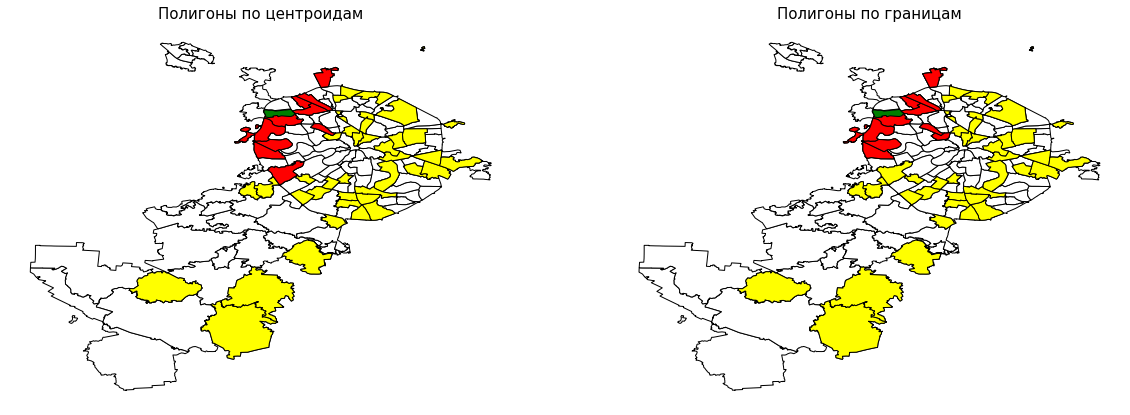

In [13]:
k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
gpd.GeoSeries(polygons).plot(ax=ax, color='yellow', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red', edgecolor='black')
gpd.GeoSeries(polygon).plot(ax=ax, color='green', edgecolor='black')
plt.title("Полигоны по центроидам", fontsize=15)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
gpd.GeoSeries(polygons).plot(ax=ax, color='yellow', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red', edgecolor='black')
gpd.GeoSeries(polygon).plot(ax=ax, color='green', edgecolor='black')
plt.title("Полигоны по границам", fontsize=15)
ax.set_axis_off()

#### Отображение результата с помощью Folium

Если навести на красные области, то отобразится расстояние до целового полигона.

In [152]:
m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=10)

by_centroid = folium.Choropleth(
    geo_data=k_nearest_neighbours_by_centroid[["geometry", "Distance_by_centroid"]].to_json(),
    data=pd.DataFrame({"ID": k_nearest_neighbours_by_centroid.index,
              "Distance_by_centroid": k_nearest_neighbours_by_centroid["Distance_by_centroid"]}),
    columns=["ID", "Distance_by_centroid"],
    key_on="feature.id",
    fill_color="YlGn",
    nan_fill_color="red",
    nan_fill_opacity=1,
    name="10 nearest by centroid").add_to(m)
folium.GeoJsonTooltip(
fields=["Distance_by_centroid"]).add_to(by_centroid.geojson)

by_board = folium.Choropleth(
    geo_data=k_nearest_neighbours_by_board[["geometry", "Distance_by_board"]].to_json(),
    data=pd.DataFrame({"ID": k_nearest_neighbours_by_board.index,
              "Distance_by_board": k_nearest_neighbours_by_board["Distance_by_board"]}),
    columns=["ID", "Distance_by_board"],
    key_on="feature.id",
    fill_color="YlGn",
    nan_fill_color="red",
    nan_fill_opacity=1,
    name="10 nearest by board").add_to(m)
folium.GeoJsonTooltip(
fields=["Distance_by_board"]).add_to(by_board.geojson)

folium.Choropleth(
    geo_data=gpd.GeoDataFrame({'geometry': polygons}).to_json(),
    data=pd.DataFrame({"ID": k_nearest_neighbours_by_centroid.index,
              "Distance_by_centroid": np.nan}),
    columns=["ID", "Distance_by_centroid"],
    key_on="feature.id",
    fill_color="BuPu",
    nan_fill_color="yellow",
    nan_fill_opacity=0.3,
    name="Base polygons").add_to(m)

m.choropleth(polygon, fill_color='green', name='Target polygon', fill_opacity=1)

folium.LayerControl().add_to(m)
m

### Упражнение 3
* Реализуйте функцию `spatial_resample`, выполняющую пространственное агрегирование. 
  На вход функция принимает:
  - `init_polygons` - изначальное гео-разбиение
  - `agg_polygons` - новое гео-разбиение, по которому будет проводится пространственное агрегирование
  - `column` - название столбца количественной переменной в `init_polygons`, которая будет агрегирована  
  - `method` - метод аггрегирования: `sum` - сумма значений, `mean` - среднее значение
  - `kind` - способ аггрегирования при частичном пересечении полигонов из `agg_polygons` и `init_polygons`, `max` - отнести значение в `column` к полигону из `agg_polygons` с которым площадь пересечения максимальна, `prop` - разбить значение в `column` пропорционально площадям пересечений

#### Функция

In [236]:
def spatial_resample(agg_polygons, init_polygons, 
                                       method='mean', column='random_value', kind='mean'):
    # Сохраним для удобства начальные площади маленьких разбиений
    init_polygons['area_initial'] = init_polygons.geometry.area
    # Вольём изначальное гео-разбиение в новое
    new_resample = gpd.sjoin(agg_polygons, init_polygons, op='intersects')
    new_resample = new_resample.reset_index()
    # Добавим столбец с площадями разбиений, чтобы пересчитать значения column
    new_resample['area_of_intersection'] = [
        new_resample.iloc[i]['geometry'].intersection(
            init_polygons.iloc[new_resample.iloc[i]['index_right']]['geometry']).area for i in new_resample.index]
    # Пересчитаем значения столбца column в соответствии со способом kind
    if kind == 'mean':
        new_resample[column] = new_resample[column] * new_resample['area_of_intersection'] / (
            new_resample['area_initial'])
    elif kind == 'max':
        # Создадим вспомогательный столбец, где будут записаны максимумы значения area_of_intersection,
        # группированные по столбцу index_right
        new_resample['area_of_intersection_max'] = new_resample.groupby(
            ['index_right'])['area_of_intersection'].transform(lambda x: max(x))
        # В столбце column укажем нули в тех строках, где area_of_intersection не равно area_of_intersection_max
        new_resample[column] = (new_resample.apply(
            lambda x: x[column] if x.area_of_intersection == x.area_of_intersection_max else 0, axis=1))
    else:
        print("Unknown kind")
        return
    # С помощью dissolve уберём повторяющиеся области из датафрейма с применением заданного метода
    new_resample = new_resample[['FID_left', 'geometry', column]].dissolve(by=new_resample['FID_left'], aggfunc=method, 
                                                       sort=False)  # Чтобы быстрее считалось
    new_resample['FID_left'] = new_resample.index
    return new_resample

In [237]:
grid_big_moscow = gpd.read_file('../data/grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

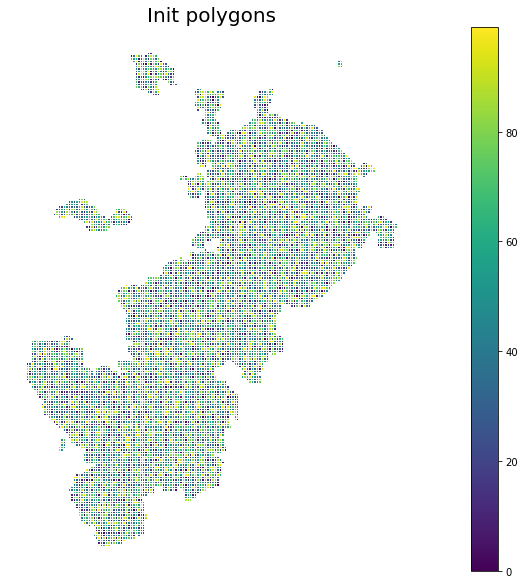

In [238]:
fig = plt.figure(figsize=(20, 10))
plt.title('Init polygons', fontsize=20)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

#### Результаты работы программы

4 датафрейма, отрисованы по две штуки

In [239]:
resample_sum_max = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')
resample_sum_max

<ipython-input-236-11a1f6b248b6>:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  init_polygons['area_initial'] = init_polygons.geometry.area


geometry  FID_left  \
FID_left                                                                
0         POLYGON ((37.70719 55.89233, 37.70734 55.89226...         0   
67        POLYGON ((37.68111 55.86191, 37.68115 55.86188...        67   
62        POLYGON ((37.73156 55.88562, 37.73210 55.88532...        62   
2         POLYGON ((37.67153 55.89692, 37.67182 55.89722...         2   
1         POLYGON ((37.59162 55.87594, 37.58753 55.87508...         1   
...                                                     ...       ...   
131       POLYGON ((37.56717 55.48776, 37.56679 55.48779...       131   
133       POLYGON ((37.58566 55.54575, 37.58553 55.54555...       133   
134       POLYGON ((37.59618 55.56176, 37.59335 55.56025...       134   
138       POLYGON ((37.60473 55.57476, 37.60443 55.57460...       138   
142       POLYGON ((37.13266 55.60558, 37.13344 55.60577...       142   

          random_value  
FID_left                
0                 1295  
67                 886  
62                1701  
2                 1184  
1                  740  
...                ...  
131               1386  
133               5838  
134               1731  
138               1921  
142               2324  

[146 rows x 3 columns]

In [240]:
resample_mean_max = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
resample_mean_max

<ipython-input-236-11a1f6b248b6>:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  init_polygons['area_initial'] = init_polygons.geometry.area


geometry  FID_left  \
FID_left                                                                
0         POLYGON ((37.70719 55.89233, 37.70734 55.89226...         0   
67        POLYGON ((37.68111 55.86191, 37.68115 55.86188...        67   
62        POLYGON ((37.73156 55.88562, 37.73210 55.88532...        62   
2         POLYGON ((37.67153 55.89692, 37.67182 55.89722...         2   
1         POLYGON ((37.59162 55.87594, 37.58753 55.87508...         1   
...                                                     ...       ...   
131       POLYGON ((37.56717 55.48776, 37.56679 55.48779...       131   
133       POLYGON ((37.58566 55.54575, 37.58553 55.54555...       133   
134       POLYGON ((37.59618 55.56176, 37.59335 55.56025...       134   
138       POLYGON ((37.60473 55.57476, 37.60443 55.57460...       138   
142       POLYGON ((37.13266 55.60558, 37.13344 55.60577...       142   

          random_value  
FID_left                
0            32.375000  
67           26.058824  
62           30.927273  
2            29.600000  
1            38.947368  
...                ...  
131          25.666667  
133          39.181208  
134          32.660377  
138          32.559322  
142          40.771930  

[146 rows x 3 columns]

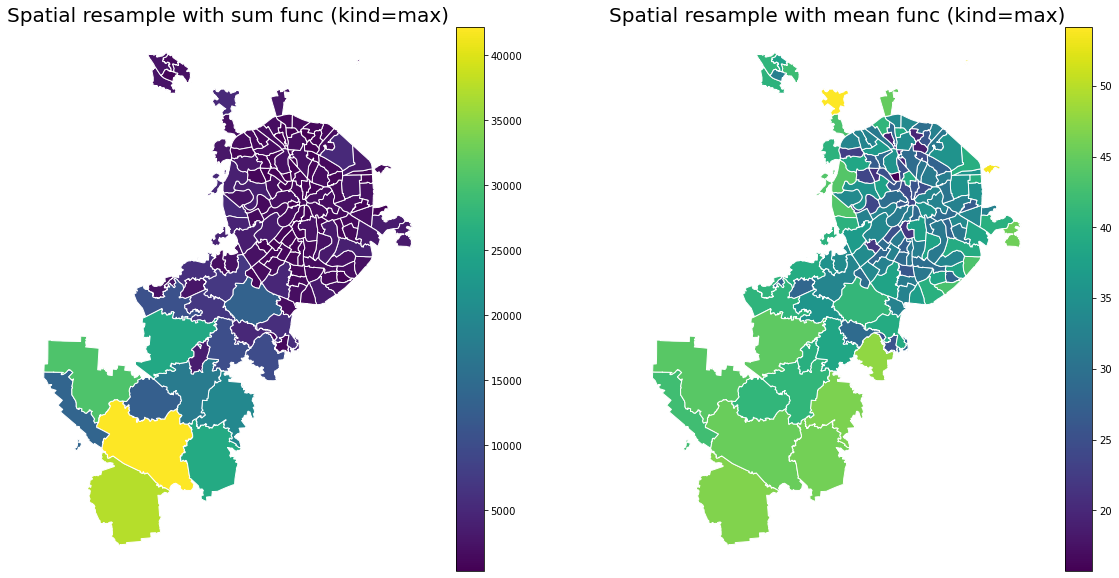

In [241]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func (kind=max)', fontsize=20)
resample_sum_max.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func (kind=max)', fontsize=20)
resample_mean_max.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

In [242]:
resample_sum_mean = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='mean')
resample_sum_mean

<ipython-input-236-11a1f6b248b6>:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  init_polygons['area_initial'] = init_polygons.geometry.area


geometry  FID_left  \
FID_left                                                                
0         POLYGON ((37.70719 55.89233, 37.70734 55.89226...         0   
67        POLYGON ((37.68111 55.86191, 37.68115 55.86188...        67   
62        POLYGON ((37.73156 55.88562, 37.73210 55.88532...        62   
2         POLYGON ((37.67153 55.89692, 37.67182 55.89722...         2   
1         POLYGON ((37.59162 55.87594, 37.58753 55.87508...         1   
...                                                     ...       ...   
131       POLYGON ((37.56717 55.48776, 37.56679 55.48779...       131   
133       POLYGON ((37.58566 55.54575, 37.58553 55.54555...       133   
134       POLYGON ((37.59618 55.56176, 37.59335 55.56025...       134   
138       POLYGON ((37.60473 55.57476, 37.60443 55.57460...       138   
142       POLYGON ((37.13266 55.60558, 37.13344 55.60577...       142   

          random_value  
FID_left                
0          1104.925082  
67          841.640614  
62         1594.809740  
2           978.922650  
1           721.087786  
...                ...  
131        1355.169076  
133        5411.823646  
134        1675.652818  
138        1887.530757  
142        1769.561006  

[146 rows x 3 columns]

In [243]:
resample_mean_mean = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='mean')
resample_mean_mean

<ipython-input-236-11a1f6b248b6>:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  init_polygons['area_initial'] = init_polygons.geometry.area


geometry  FID_left  \
FID_left                                                                
0         POLYGON ((37.70719 55.89233, 37.70734 55.89226...         0   
67        POLYGON ((37.68111 55.86191, 37.68115 55.86188...        67   
62        POLYGON ((37.73156 55.88562, 37.73210 55.88532...        62   
2         POLYGON ((37.67153 55.89692, 37.67182 55.89722...         2   
1         POLYGON ((37.59162 55.87594, 37.58753 55.87508...         1   
...                                                     ...       ...   
131       POLYGON ((37.56717 55.48776, 37.56679 55.48779...       131   
133       POLYGON ((37.58566 55.54575, 37.58553 55.54555...       133   
134       POLYGON ((37.59618 55.56176, 37.59335 55.56025...       134   
138       POLYGON ((37.60473 55.57476, 37.60443 55.57460...       138   
142       POLYGON ((37.13266 55.60558, 37.13344 55.60577...       142   

          random_value  
FID_left                
0            27.623127  
67           24.754136  
62           28.996541  
2            24.473066  
1            37.951989  
...                ...  
131          25.095724  
133          36.320964  
134          31.616091  
138          31.992047  
142          31.044930  

[146 rows x 3 columns]

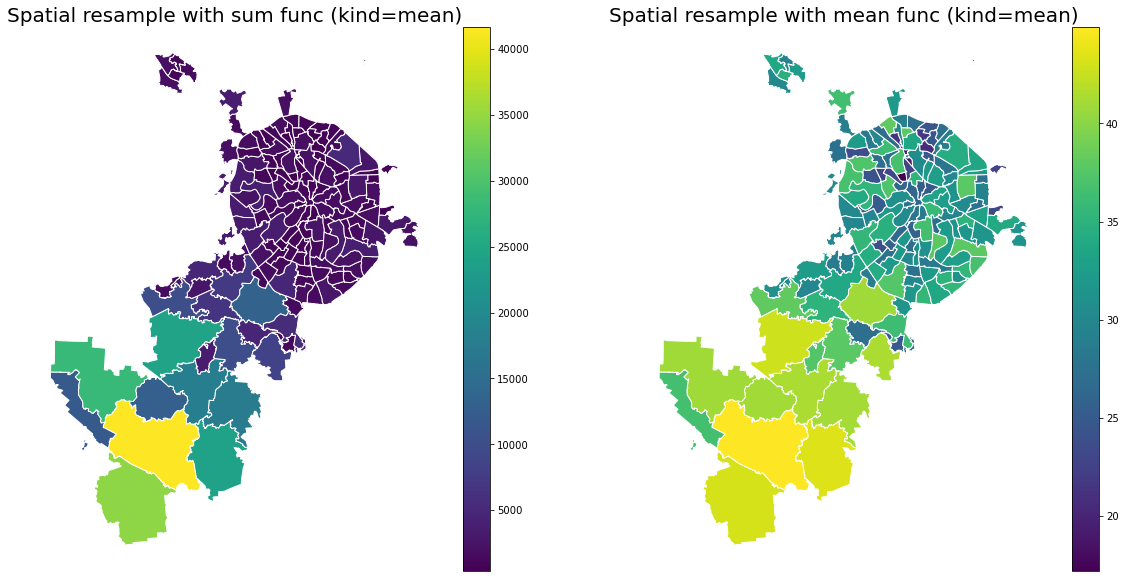

In [244]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func (kind=mean)', fontsize=20)
resample_sum_mean.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func (kind=mean)', fontsize=20)
resample_mean_mean.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

#### Отрисуем в Folium 

Если открыть один конкретный слой, то при наведении на область отобразится значения её random_value

In [245]:
names_of_layers = ['resample_sum_max', 'resample_mean_max', 'resample_sum_mean', 'resample_mean_mean']
list_of_Choropleths = []

m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=9)

for i, resample in enumerate([resample_sum_max, resample_mean_max, resample_sum_mean, resample_mean_mean]):
    list_of_Choropleths.append(folium.Choropleth(
        geo_data=resample[["geometry", "FID_left", "random_value"]].to_json(),
        data=pd.DataFrame({"FID_left": resample.index,
                  "random_value": resample["random_value"]},
                 index=np.arange(len(resample))),
        columns=["FID_left", "random_value"],
        key_on="feature.properties.FID_left",
        fill_color="BuPu",
        name=names_of_layers[i],
        legend_name=names_of_layers[i]).add_to(m))
    
    folium.GeoJsonTooltip(
        fields=["random_value"]).add_to(list_of_Choropleths[i].geojson)

folium.LayerControl().add_to(m)
m